In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "rbc_phase"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = 0


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

RBC Dataset V.2 => All pateints
Dataset split type train, image type: phase


Loaded 2752 images
RBC Dataset V.2 => All pateints
Dataset split type val, image type: phase


Loaded 928 images
RBC Dataset V.2 => All pateints
Dataset split type test, image type: phase


Loaded 928 images
RBC Dataset V.2 => All pateints
Dataset split type train, image type: phase


Loaded 1462 images
RBC Dataset V.2 => All pateints
Dataset split type val, image type: phase


Loaded 493 images
RBC Dataset V.2 => All pateints
Dataset split type test, image type: phase


Loaded 493 images


In [6]:
# model ids
model_ids = {"0": '3n43g5vq', "1": 'nzua9nlo', "": "vjmdj6q8"}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

0 3n43g5vq


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                     | 0/43 [00:00<?, ?it/s]

  2%|██▏                                                                                          | 1/43 [00:01<00:44,  1.06s/it]

  7%|██████▍                                                                                      | 3/43 [00:01<00:12,  3.11it/s]

 12%|██████████▊                                                                                  | 5/43 [00:01<00:07,  5.38it/s]

 16%|███████████████▏                                                                             | 7/43 [00:01<00:04,  7.63it/s]

 21%|███████████████████▍                                                                         | 9/43 [00:01<00:03,  9.76it/s]

 26%|███████████████████████▌                                                                    | 11/43 [00:01<00:02, 11.61it/s]

 30%|███████████████████████████▊                                                                | 13/43 [00:01<00:02, 13.18it/s]

 35%|████████████████████████████████                                                            | 15/43 [00:01<00:01, 14.38it/s]

 40%|████████████████████████████████████▎                                                       | 17/43 [00:01<00:01, 15.34it/s]

 44%|████████████████████████████████████████▋                                                   | 19/43 [00:02<00:01, 15.97it/s]

 49%|████████████████████████████████████████████▉                                               | 21/43 [00:02<00:01, 16.57it/s]

 53%|█████████████████████████████████████████████████▏                                          | 23/43 [00:02<00:01, 16.95it/s]

 58%|█████████████████████████████████████████████████████▍                                      | 25/43 [00:02<00:01, 17.26it/s]

 63%|█████████████████████████████████████████████████████████▊                                  | 27/43 [00:02<00:00, 17.50it/s]

 67%|██████████████████████████████████████████████████████████████                              | 29/43 [00:02<00:00, 17.64it/s]

 72%|██████████████████████████████████████████████████████████████████▎                         | 31/43 [00:02<00:00, 17.78it/s]

 77%|██████████████████████████████████████████████████████████████████████▌                     | 33/43 [00:02<00:00, 17.83it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                 | 35/43 [00:02<00:00, 17.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▏            | 37/43 [00:03<00:00, 17.95it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▍        | 39/43 [00:03<00:00, 18.17it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▋    | 41/43 [00:03<00:00, 18.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00, 18.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00, 12.48it/s]

train - OK


  0%|                                                                                                     | 0/15 [00:00<?, ?it/s]

  7%|██████▏                                                                                      | 1/15 [00:00<00:04,  3.05it/s]

 20%|██████████████████▌                                                                          | 3/15 [00:00<00:01,  7.77it/s]

 33%|███████████████████████████████                                                              | 5/15 [00:00<00:00, 10.91it/s]

 47%|███████████████████████████████████████████▍                                                 | 7/15 [00:00<00:00, 13.08it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 9/15 [00:00<00:00, 14.68it/s]

 73%|███████████████████████████████████████████████████████████████████▍                        | 11/15 [00:00<00:00, 15.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▋            | 13/15 [00:00<00:00, 16.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 17.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.04it/s]

val - OK


  0%|                                                                                                     | 0/15 [00:00<?, ?it/s]

  7%|██████▏                                                                                      | 1/15 [00:00<00:04,  3.19it/s]

 20%|██████████████████▌                                                                          | 3/15 [00:00<00:01,  8.04it/s]

 33%|███████████████████████████████                                                              | 5/15 [00:00<00:00, 11.14it/s]

 47%|███████████████████████████████████████████▍                                                 | 7/15 [00:00<00:00, 13.31it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 9/15 [00:00<00:00, 14.90it/s]

 73%|███████████████████████████████████████████████████████████████████▍                        | 11/15 [00:00<00:00, 16.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▋            | 13/15 [00:00<00:00, 16.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.57it/s]

test InD - OK


  0%|                                                                                                     | 0/39 [00:00<?, ?it/s]

  3%|██▍                                                                                          | 1/39 [00:00<00:11,  3.20it/s]

  8%|███████▏                                                                                     | 3/39 [00:00<00:04,  8.05it/s]

 13%|███████████▉                                                                                 | 5/39 [00:00<00:03, 11.20it/s]

 18%|████████████████▋                                                                            | 7/39 [00:00<00:02, 13.29it/s]

 23%|█████████████████████▍                                                                       | 9/39 [00:00<00:02, 14.73it/s]

 28%|█████████████████████████▉                                                                  | 11/39 [00:00<00:01, 15.70it/s]

 33%|██████████████████████████████▋                                                             | 13/39 [00:00<00:01, 16.37it/s]

 38%|███████████████████████████████████▍                                                        | 15/39 [00:01<00:01, 16.86it/s]

 44%|████████████████████████████████████████                                                    | 17/39 [00:01<00:01, 17.22it/s]

 49%|████████████████████████████████████████████▊                                               | 19/39 [00:01<00:01, 17.41it/s]

 54%|█████████████████████████████████████████████████▌                                          | 21/39 [00:01<00:01, 17.63it/s]

 59%|██████████████████████████████████████████████████████▎                                     | 23/39 [00:01<00:00, 17.78it/s]

 64%|██████████████████████████████████████████████████████████▉                                 | 25/39 [00:01<00:00, 17.82it/s]

 69%|███████████████████████████████████████████████████████████████▋                            | 27/39 [00:01<00:00, 17.85it/s]

 74%|████████████████████████████████████████████████████████████████████▍                       | 29/39 [00:01<00:00, 17.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                  | 31/39 [00:01<00:00, 17.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▊              | 33/39 [00:02<00:00, 18.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▌         | 35/39 [00:02<00:00, 18.25it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▎    | 37/39 [00:02<00:00, 18.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 15.85it/s]

test OoD - OK


  0%|                                                                                                    | 0/100 [00:00<?, ?it/s]

  2%|█▊                                                                                          | 2/100 [00:00<00:04, 19.77it/s]

  5%|████▌                                                                                       | 5/100 [00:00<00:04, 20.03it/s]

  8%|███████▎                                                                                    | 8/100 [00:00<00:04, 20.13it/s]

 11%|██████████                                                                                 | 11/100 [00:00<00:04, 20.16it/s]

 14%|████████████▋                                                                              | 14/100 [00:00<00:04, 20.17it/s]

 17%|███████████████▍                                                                           | 17/100 [00:00<00:04, 20.21it/s]

 20%|██████████████████▏                                                                        | 20/100 [00:00<00:03, 20.22it/s]

 23%|████████████████████▉                                                                      | 23/100 [00:01<00:03, 20.21it/s]

 26%|███████████████████████▋                                                                   | 26/100 [00:01<00:03, 20.20it/s]

 29%|██████████████████████████▍                                                                | 29/100 [00:01<00:03, 20.20it/s]

 32%|█████████████████████████████                                                              | 32/100 [00:01<00:03, 20.18it/s]

 35%|███████████████████████████████▊                                                           | 35/100 [00:01<00:03, 20.18it/s]

 38%|██████████████████████████████████▌                                                        | 38/100 [00:01<00:03, 20.16it/s]

 41%|█████████████████████████████████████▎                                                     | 41/100 [00:02<00:02, 20.16it/s]

 44%|████████████████████████████████████████                                                   | 44/100 [00:02<00:02, 20.15it/s]

 47%|██████████████████████████████████████████▊                                                | 47/100 [00:02<00:02, 20.16it/s]

 50%|█████████████████████████████████████████████▌                                             | 50/100 [00:02<00:02, 20.18it/s]

 53%|████████████████████████████████████████████████▏                                          | 53/100 [00:02<00:02, 20.17it/s]

 56%|██████████████████████████████████████████████████▉                                        | 56/100 [00:02<00:02, 20.17it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 59/100 [00:02<00:02, 20.17it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 62/100 [00:03<00:01, 20.15it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 65/100 [00:03<00:01, 20.16it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 68/100 [00:03<00:01, 20.17it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 71/100 [00:03<00:01, 20.17it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 74/100 [00:03<00:01, 20.19it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 77/100 [00:03<00:01, 20.20it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 80/100 [00:03<00:00, 20.21it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 83/100 [00:04<00:00, 20.14it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 86/100 [00:04<00:00, 20.16it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 89/100 [00:04<00:00, 20.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 92/100 [00:04<00:00, 20.17it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 95/100 [00:04<00:00, 20.17it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [00:04<00:00, 20.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.16it/s]

test RnD - OK
(2752,) (2752,)
(928,) (928,)
(928,) (928,)
(2448,) (2448,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

7.055257 1.36938
6.9924083 1.2870922
7.064105 1.3725859
6.6950684 1.0310951
19.005684 1.0009657
58.978493 0.016574923
58.977455 0.014407468
58.98159 0.073973455
58.978695 0.04484702
59.356983 0.36115134


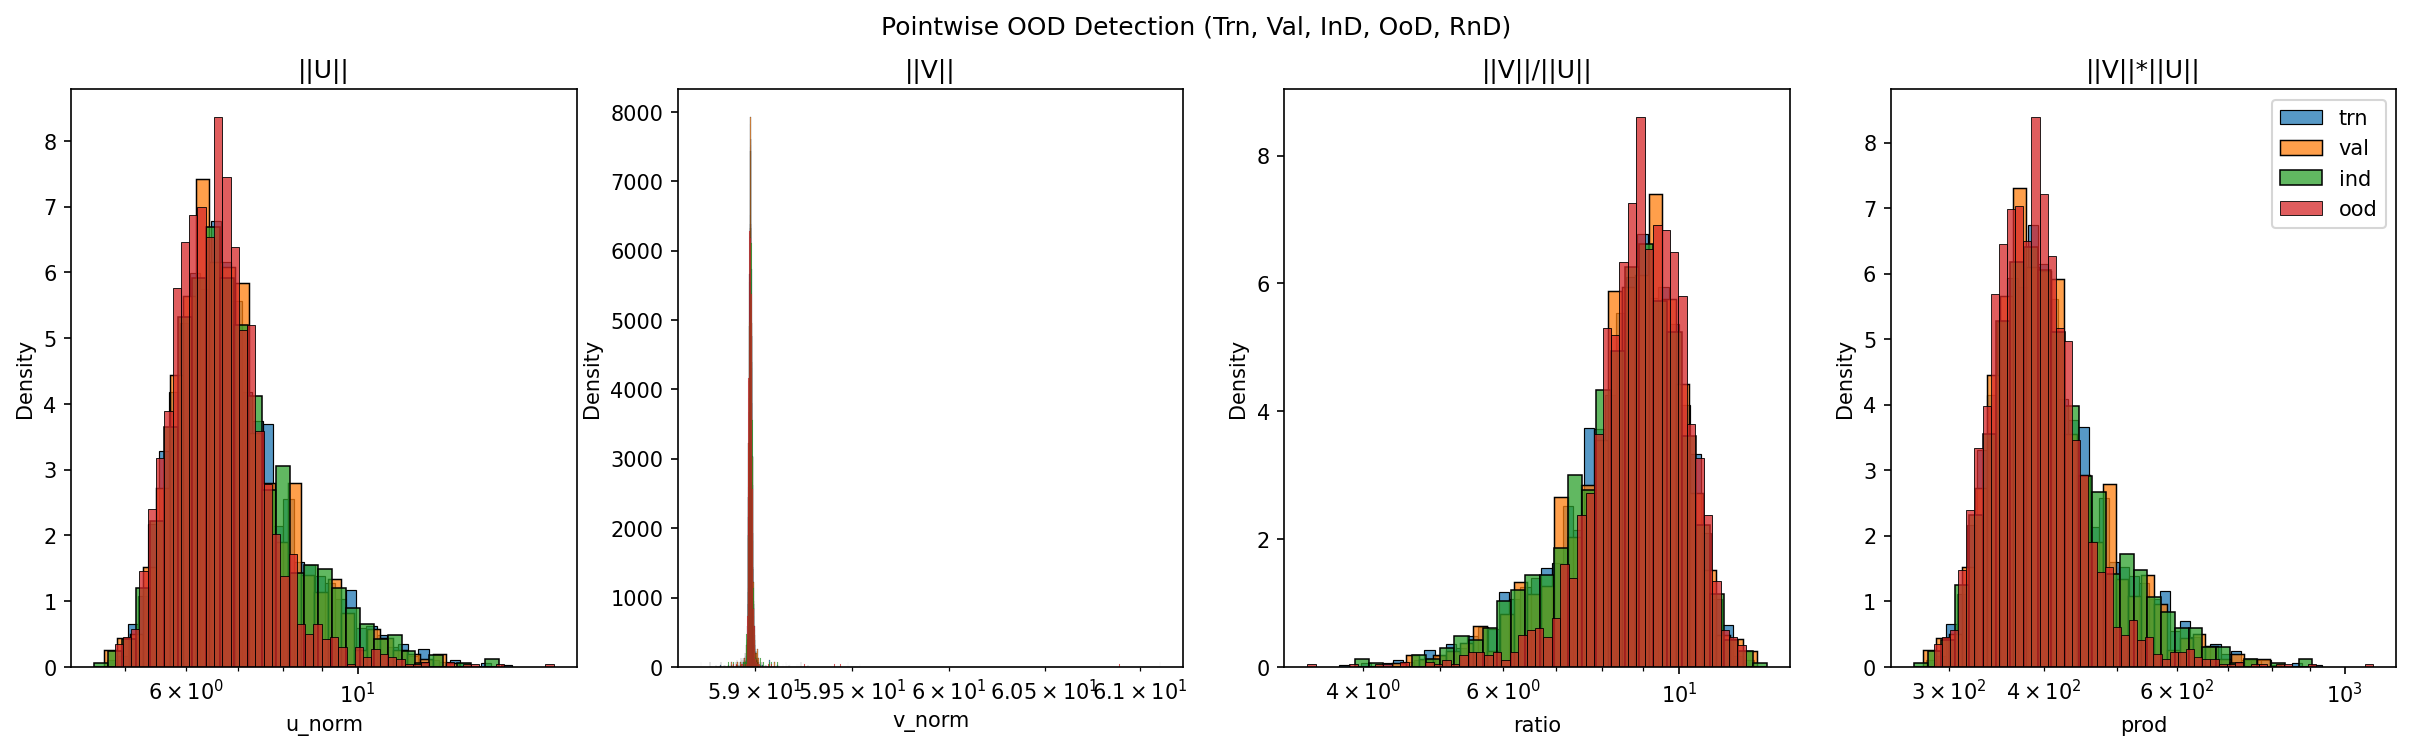

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 58.801113 59.271526 0.4704132
Val 58.769382 59.1005 0.33111572
Ind 58.723778 61.10839 2.384613
Ood 58.87257 60.894077 2.0215073
Rnd 57.973186 60.594624 2.621437
KstestResult(statistic=0.10149030876718504, pvalue=1.7224095351323586e-06, statistic_location=58.977123, statistic_sign=-1)


[0 1]


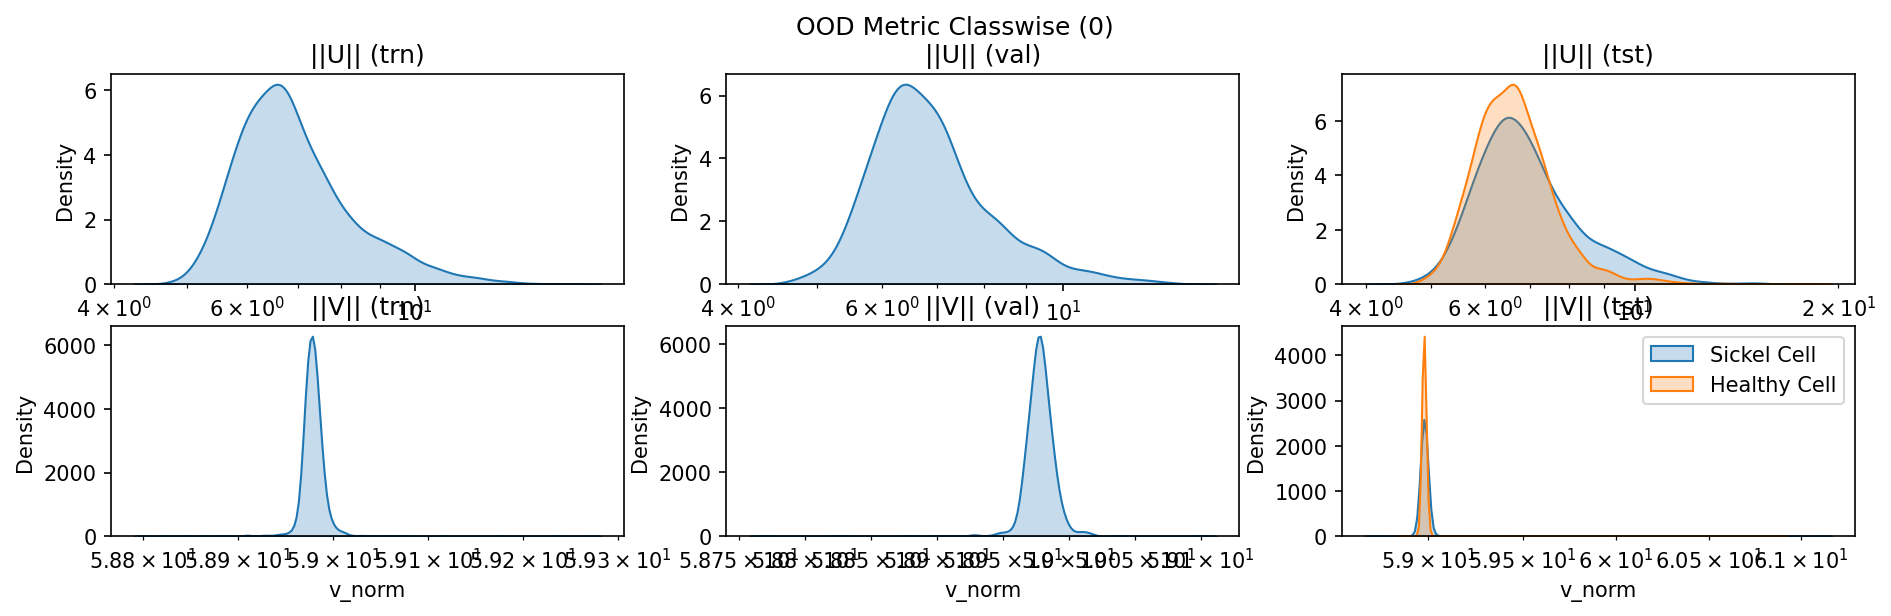

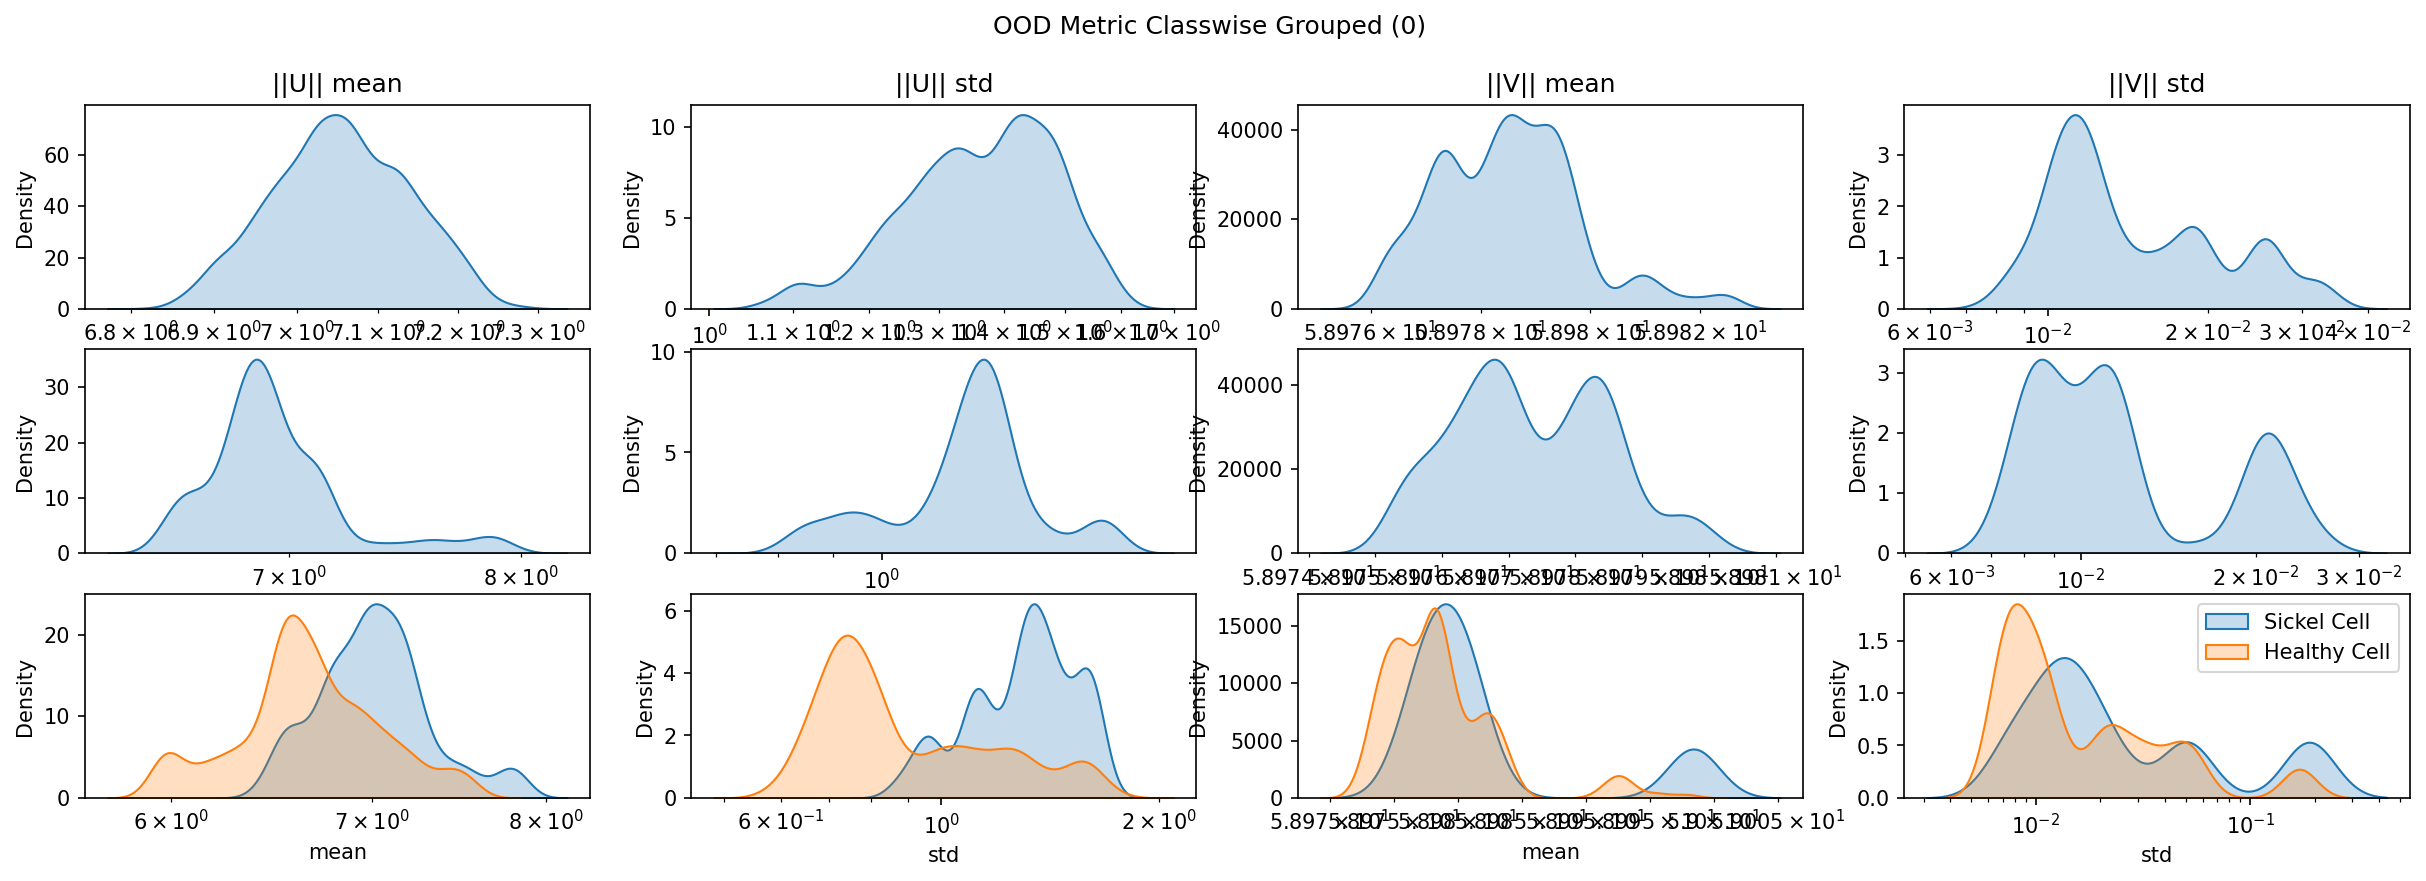

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)